In [1]:
#  Import stuff

import pickle

import numpy             as np
import matplotlib.pyplot as plt

import keras.backend   as     K
from   keras.callbacks import EarlyStopping
from   keras.models    import Sequential
from   keras.layers    import Dense, Flatten, Conv2D

Using TensorFlow backend.


In [2]:
#  Load pickled data

pickle_file = 'psl_ann_natl_1850_3049.pkl'
psl, lon, lat = pickle.load(open(pickle_file, 'rb'), encoding='latin1')
print(f"PSL has shape {psl.shape} with {lon.shape} longitude and {lat.shape} latitude coordinates")
print(f"PSL elements are objects of type {type(psl[0, 0,0 ])}")

num_samples = psl.shape[0]
j_length, i_length = len(lat), len(lon)

np.random.shuffle(psl)

PSL has shape (1200, 72, 65) with (65,) longitude and (72,) latitude coordinates
PSL elements are objects of type <class 'numpy.float32'>


In [3]:
#  Create NAO index

j_lisbon , i_lisbon  = 102-71, 140-104  # Lisbon
j_iceland, i_iceland = 121-71, 135-104  # Iceland
nao = psl[:, j_lisbon, i_lisbon] - psl[:, j_iceland, i_iceland]

In [4]:
# Make training, validation and test datasets

num_train, num_val, num_test = 700, 250, 250
idx_split = num_train + num_val
if num_train + num_val + num_test != num_samples :
    print("WARNING\t\tTRAIN({num_train}) + VAL({num_val}) + TEST({num_test}) SAMPLES != TOTAL ({num_samples})")

# Put the PSL into the range [0, 1]
psl_min, psl_range   = psl.min(), np.ptp(psl)
images_train = (psl[:num_train         , :, :] - psl_min) / psl_range
images_val   = (psl[num_train:idx_split, :, :] - psl_min) / psl_range
images_test  = (psl[idx_split:         , :, :] - psl_min) / psl_range

y_train = nao[:num_train        ]
y_val   = nao[num_train:idx_split]
y_test  = nao[idx_split:         ]

images_train = images_train.reshape([num_train, j_length, i_length, 1])
images_val   = images_val  .reshape([num_val  , j_length, i_length, 1])
images_test  = images_test .reshape([num_test , j_length, i_length, 1])

In [5]:
# Define model

def create_model () :
    model = Sequential()
    model.add(Conv2D(10, kernel_size=(3, 3), input_shape=(j_length, i_length, 1), activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [6]:
# Create new model instance

model = create_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 63, 10)        100       
_________________________________________________________________
flatten_1 (Flatten)          (None, 44100)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                441010    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 441,231
Trainable params: 441,231
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
# Fit model to training data, stopping when description of validation data stops improving

model.load_weights("good_model_backup.mod")

# Uncomment this to fit the model (takes about 10 minutes to get really good)
'''
model.fit(images_train,
          y_train, 
          validation_data=(images_val, y_val),
          epochs=1000, 
          callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])
'''

"\nmodel.fit(images_train,\n          y_train, \n          validation_data=(images_val, y_val),\n          epochs=1000, \n          callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])\n"

In [8]:
# Save model for backup

model.save_weights("good_model.mod")

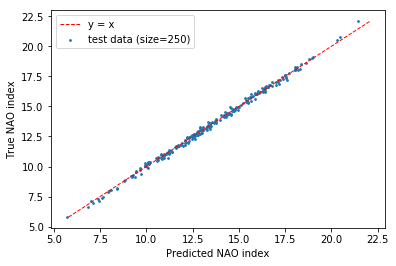

In [9]:
# Get model predictions on test dataset, and plot correlation with ground truth

pred_test = model.predict(images_test)

xp = np.linspace(min(y_test), max(y_test), 2)
plt.plot(xp, xp, "--", c="r", label="y = x", linewidth=1)
plt.scatter(pred_test, y_test, s=3, label=f"test data (size={len(y_test)})")
plt.xlabel("Predicted NAO index")
plt.ylabel("True NAO index")
plt.legend(loc="upper left")
plt.show()

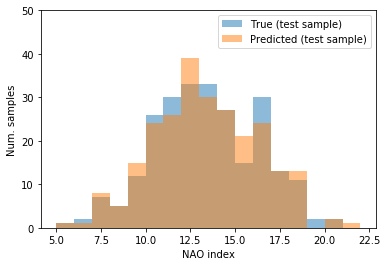

In [10]:
# Plot ground truth and prediction distributions

plt.hist(y_test   , bins=np.linspace(5,22,18), alpha=0.5, label="True (test sample)")
plt.hist(pred_test, bins=np.linspace(5,22,18), alpha=0.5, label="Predicted (test sample)")
plt.gca().set_ylim(0, 50)
plt.ylabel("Num. samples")
plt.xlabel("NAO index")
plt.legend(loc="upper right")
plt.show()

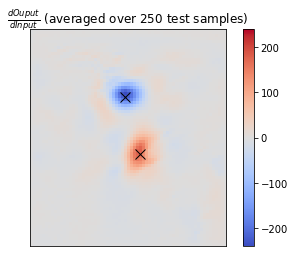

In [11]:
# Plot dOutput / dInput (averaged over all test samples)

cmap = plt.get_cmap('coolwarm')

grad = K.gradients(model.output, [model.input])[0]
fn   = K.function([model.input], [grad])

grad_maps = fn([images_test])[0]

average_grad_map = np.zeros(shape=(j_length, i_length))
for m in grad_maps : average_grad_map = average_grad_map + m[:,:,0]

grad_max = max(np.max(average_grad_map), np.fabs(np.min(average_grad_map)))
plt.imshow(np.flip(average_grad_map, axis=0), cmap=cmap, vmin=-1.*grad_max, vmax=grad_max)
plt.colorbar()
plt.plot(i_lisbon , j_length-j_lisbon , 'x', color='k', markersize=10)
plt.plot(i_iceland, j_length-j_iceland, 'x', color='k', markersize=10)
plt.title(r"$\frac{dOuput}{dInput}$ (averaged over "+f"{len(grad_maps)} test samples)")
plt.xticks([])
plt.yticks([])
plt.show()

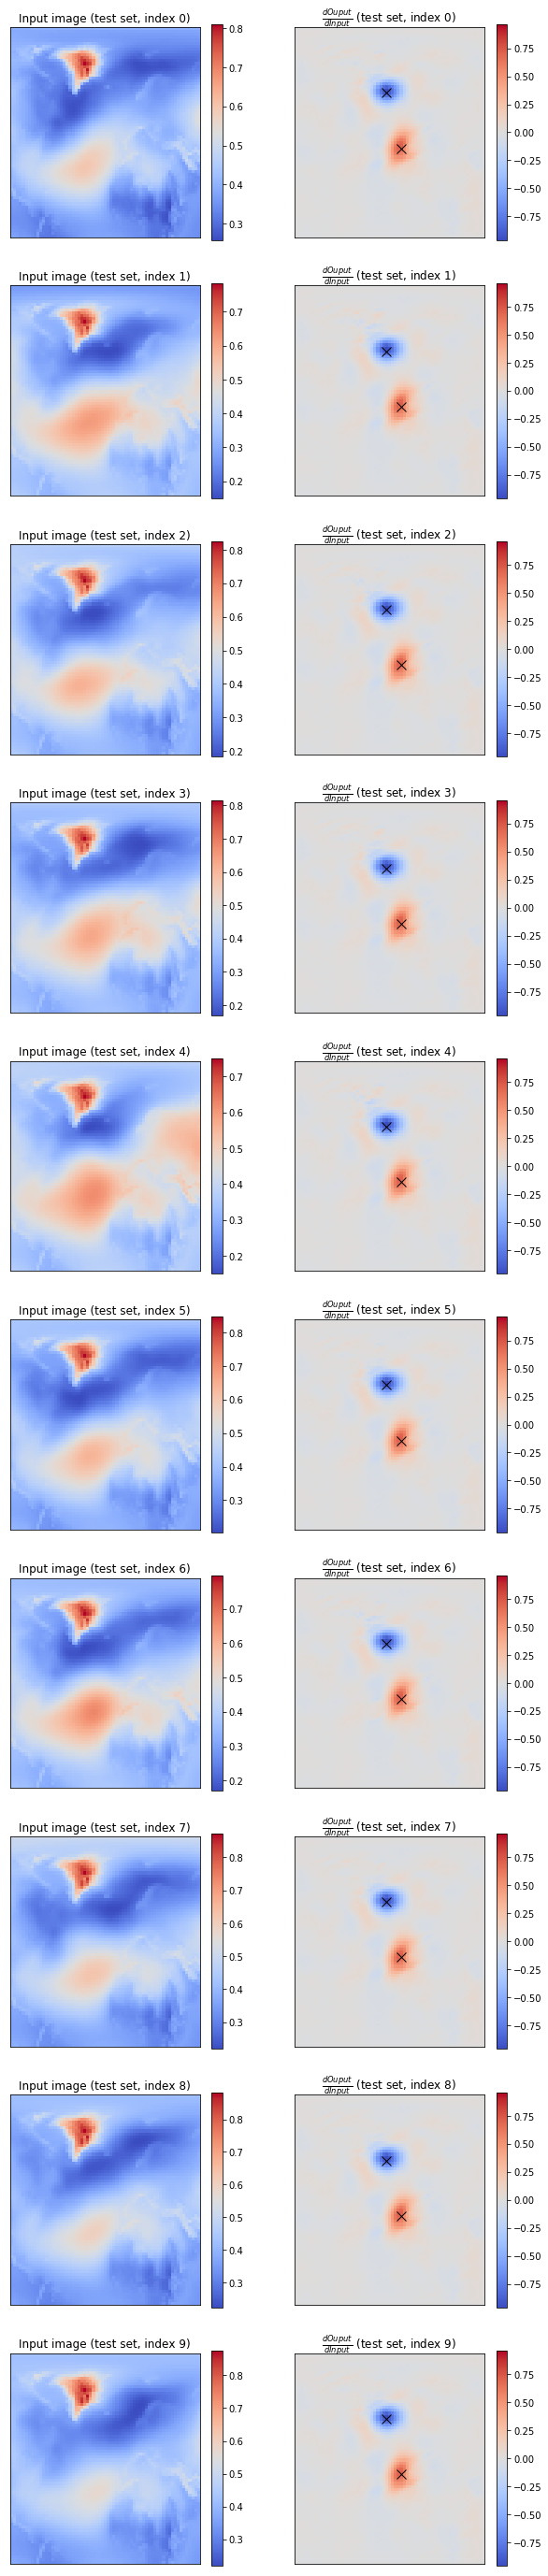

In [12]:
# Plot dOutput / dInput (individually for a few test samples)

n_plots = 10
fig = plt.figure(figsize=(10, 5*n_plots))
for i in range(n_plots) :
    ax = fig.add_subplot(n_plots, 2, (2*i)+1)
    plt.imshow(np.flip(images_test[i,:,:,0], axis=0), cmap=cmap)
    plt.colorbar()
    plt.title(f"Input image (test set, index {i})")
    plt.xticks([])
    plt.yticks([])
    ax = fig.add_subplot(n_plots, 2, (2*i)+2)
    image = np.flip(grad_maps  [i,:,:,0], axis=0)
    grad_max = max(np.max(image), np.fabs(np.min(image)))
    plt.imshow(image, cmap=cmap, vmin=-1.*grad_max, vmax=grad_max)
    plt.colorbar()
    plt.plot(i_lisbon , j_length-j_lisbon , 'x', color='k', markersize=10)
    plt.plot(i_iceland, j_length-j_iceland, 'x', color='k', markersize=10)
    plt.title(r"$\frac{dOuput}{dInput}$ "+f"(test set, index {i})")
    plt.xticks([])
    plt.yticks([])